# **Построение модели МО для бинарной классификации**

## **Загрузка датасета и его предобработка**

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


PassengerId и Name не содержит полезной информации.

Ticket и Cabin, возможно, могут оказаться полезными, но при использовании нейросетей, так как, вероятно, классическое МО не выявит сложных связей в этих данных.

In [5]:
data = df.copy()

In [6]:
data = data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])


In [7]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [8]:
data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


In [9]:
# Исключим строки с пропусками Embarked, а возраст возьмем медианный

data = data.dropna(subset=["Embarked"]).copy()

data["Age"] = data["Age"].fillna(data["Age"].median())

In [10]:
data.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [11]:
# Обработаем категориальные признаки

data["Sex"] = data["Sex"].map({"male": 0, "female": 1})
data = pd.get_dummies(data, columns=["Embarked"], drop_first=True)

In [12]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,True
1,1,1,1,38.0,1,0,71.2833,False,False
2,1,3,1,26.0,0,0,7.9250,False,True
3,1,1,1,35.0,1,0,53.1000,False,True
4,0,3,0,35.0,0,0,8.0500,False,True
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,False,True
887,1,1,1,19.0,0,0,30.0000,False,True
888,0,3,1,28.0,1,2,23.4500,False,True
889,1,1,0,26.0,0,0,30.0000,False,False


In [13]:
# Разделяем данные на предиктивные и предиктабл

y = data["Survived"]
X = data.drop("Survived", axis=1)

## **Выбор метрики и его обоснование**

<Axes: >

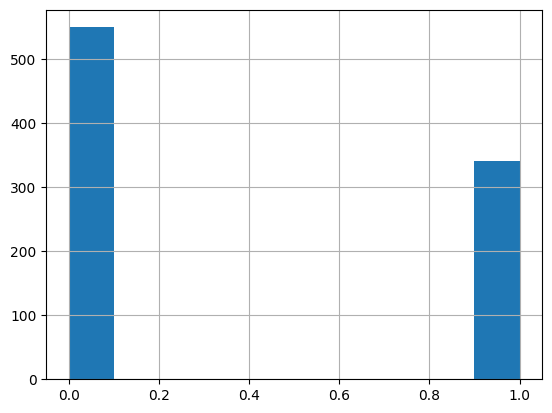

In [14]:
# Смотрим на распределение таргета

y.hist()

In [15]:
y.value_counts()

,count
Survived,
0,549
1,340


Количество классов отличается, поэтому accuracy нам не подходит. Вместо этого более подходящей метрикой будет гармоническое среднее между precision и recall, то есть f1-score.

## **Бейзлайн и МО**

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

### **Бейзлайн**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28, stratify=y)

In [18]:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

In [19]:
f1_base = f1_score(y_test, y_pred_base)
print("Бейзлайн f1-score:", f1_base)

Бейзлайн f1-score: 0.0


### **Случайный лес**

In [20]:
rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=28, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [21]:
f1_rf = f1_score(y_test, y_pred_rf)
print("Случайный лес f1-score:", f1_rf)

Случайный лес f1-score: 0.7638190954773869
